In [8]:
import numpy as np
from scipy.io import wavfile

# =======================================
# Constants
# =======================================

t_per_sample = 0.00002267573

sample_T = 1 / 44100 # Period of sample (in s)

# =======================================
# Parameters to tune for audio processing
# =======================================

g = 0.6 # Amplitude multiplier

# We use cartesian coordinates to model the motion of a point audio source
# around a listener centered around the origin

# The left ear is located at (-10, 0), the right ear at (10, 0)

left_ear_pos = np.array([-10, 0])
right_ear_pos = np.array([10, 0])

'''
Adds a spatial characteristic to an input .wav audio file

param[in] input_path : path to the input audio file
param[out] output_path : paht to the output audio file
param[in] span : [0, 100] with 100 representing an audio signal coming from the right and 0 representing an audio signal
                coming from the left
'''
# TO DO: Change parameter to accept position of audio signal in space 
# Frequency attenuation 
# Hardcode left and right channel positions relative to origin

def head_transfer_function(input_path : str, output_path : str, span : int):
    span = 0 if span < 0 else min(span, 100)

    sample_rate, data = wavfile.read(input_path)
    audio_data = np.array(data, dtype=np.float32)

    if data.dtype == np.int16:
        audio_data = audio_data / 32768.0  # 16-bit audio normalization
    elif data.dtype == np.int32:
        audio_data = audio_data / 2147483648.0  # 32-bit audio normalization
    elif data.dtype == np.uint8:
        audio_data = (audio_data - 128) / 128.0  # 8-bit audio normalization

    #sample_T = 1 / sample_rate # Period of sample (in s)

    # -100 = 0.0003
    # 0 = 0
    # 100 = 0.0003

    time_delay = 0.0003 # Time delay to imitate audio traveling from one ear to the other
    sample_shift = int(time_delay / sample_T) # Number of samples we have to shift by

    right_span = span
    left_span = 100 - span

    # Channel shifts are inversely proportional to their respective channel spans
    # thus directly proportional with the span of the opposite channel

    if span >= 50:
        right_sample_shift = 0
        left_sample_shift = int(0.0003 * ((span - 50) / 50) / sample_T)
    else:
        right_sample_shift = int(int(0.0003 * ((50 - span) / 50) / sample_T))
        left_sample_shift = 0

    left_sample_padding = right_sample_shift
    right_sample_padding = left_sample_shift

    left_amp_mult = g + (1 - g) * (left_span / 100)
    right_amp_mult = g + (1 - g) * (right_span / 100)

    '''left_amp_mult = 1 if span <= 100 else (g * (100 / (span - 100)))
    right_amp_mult = 1 if span >= 100 else (g * (100 / (100 - span)))'''

    print(f"span : left shift : right shift | {span, left_sample_shift, right_sample_shift}")
    print(f"left_amp_mult {left_amp_mult}, right_amp_mult {right_amp_mult}")

    left_channel_padded = np.array([0. for _ in range(left_sample_shift)] + [audio_data[i] for i in range(len(audio_data))] + [0. for _ in range(left_sample_padding)], 
                                   dtype=np.float32)
    left_channel_padded *= left_amp_mult
    right_channel_padded = np.array([0. for _ in range(right_sample_shift)] + [audio_data[i] for i in range(len(audio_data))] + [0. for _ in range(right_sample_padding)], 
                                   dtype=np.float32)
    right_channel_padded *= right_amp_mult

    return (left_channel_padded, right_channel_padded, sample_rate)
    

def get_span_from_point(point : np.ndarray):
    point = np.array(point)
    #dist = np.linalg.norm(left_ear_pos - point)
    r_dist = np.linalg.norm(right_ear_pos - point)
    l_dist = np.linalg.norm(left_ear_pos - point)

    diff = abs(r_dist - l_dist)
    diff = min(diff, 20)

    if r_dist <= l_dist:
        span = 50 + 50 * (diff / 20)
    else:
        span = 50 - (50 * (diff / 20))
    
    return span


In [9]:
# Returns a list of points representing the motion of a particle based on the length of time spanned by an input audio file
def model_particle_orbit(input_path : str):
    t = 0
    pos = []

    _, data = wavfile.read(input_path)
    wav = np.array(data, dtype=np.float32)

    for _ in wav:
        # Our point does a complete rotation in 2 second
        point = (-10 * np.sin(2 * np.pi * t / 2), 10 * np.cos(2 * np.pi * t / 2))
        pos.append(point)
        t += t_per_sample  
    return pos

def model_particle_orbit_in_front(input_path : str):
    t = 0
    pos = []

    _, data = wavfile.read(input_path)
    wav = np.array(data, dtype=np.float32)

    for _ in wav:
        # Our point does a complete rotation in 2 second
        point = (-10 * np.sin(2 * np.pi * t / 2), 10 * np.cos(2 * np.pi * t / 2) + 10)
        pos.append(point)
        t += t_per_sample  
    return pos

In [10]:
def spatialize_from_point(input_path : str, output_path : str, point : list):
    try:
        _, _ = point
    except ValueError:
        print(f"ERROR: Point passed into spatialize_from_point is of invalid format. Expected (x, y). Received: {point}")
        return
    
    span = get_span_from_point(point)

    left_channel_padded, right_channel_padded, sample_rate = head_transfer_function(input_path, output_path, span)

    tone_y_stereo=np.vstack((left_channel_padded, right_channel_padded))
    tone_y_stereo=tone_y_stereo.transpose()
    wavfile.write(output_path, sample_rate, tone_y_stereo)

def spatialize_from_points(input_path : str, output_path : str, points : list[list]):
    if len(points) == 0:
        print("ERROR: List of points contains no entries")
        return

    left_channel = []
    right_channel = []
    for point in points:
        try:
            _, _ = point
        except ValueError:
            print(f"ERROR: Point passed into spatialize_from_point is of invalid format. Expected (x, y). Received: {point}")
            return
        
        span = get_span_from_point(point)

        left_channel_padded, right_channel_padded, sample_rate = head_transfer_function(input_path, output_path, span)


        #left_channel = np.concatenate((left_channel, left_channel_padded))
        #right_channel = np.concatenate((right_channel, right_channel_padded))

        left_channel.append(left_channel_padded)
        right_channel.append(right_channel_padded)

        #print(sample_rate)

        print(f"Len of both channels (left, right) : {len(left_channel)}, {len(right_channel)}")
    
    #print(right_channel)

    # TO DO: Figure out why accumulating into two channels with np.concatenate was not working

    left_channel_final = []
    for audio in left_channel:
        for sample in audio:
            left_channel_final.append(sample)

    right_channel_final = []
    for audio in right_channel:
        for sample in audio:
            right_channel_final.append(sample)
    
    left_channel_final = np.array(left_channel_final)
    right_channel_final = np.array(right_channel_final)
    
    tone_y_stereo=np.vstack((left_channel_final, right_channel_final))
    tone_y_stereo=tone_y_stereo.transpose()
    wavfile.write(output_path, 44100, tone_y_stereo)

In [11]:
class RingBuf:
    # Constructor (initializer)
    def __init__(self):
        self.buf = [0. for _ in range(14)]
        #self.l_ptr = 0
        #self.r_ptr = 0
        self.w_ptr = 0

    def write(self, val : float):
        self.buf[self.w_ptr] = val
        self.w_ptr = (self.w_ptr + 1) % len(self.buf)
        #self.r_ptr = (self.r_ptr + 1) % len(self.buf)
        #self.l_ptr = (self.l_ptr + 1) % len(self.buf)
    
    def read(self, span):
        #span = get_span_from_point(pos)
        left_sample_shift = 0
        right_sample_shift = 0
        if span >= 50:
            left_sample_shift = int(0.0003 * ((span - 50) / 50) / sample_T)
            r_ptr = (self.w_ptr - 1) % len(self.buf)
            l_ptr = (self.w_ptr - left_sample_shift - 1) % len(self.buf)
        else:
            right_sample_shift = int(0.0003 * ((50 - span) / 50) / sample_T)
            l_ptr = (self.w_ptr - 1) % len(self.buf)
            r_ptr = (self.w_ptr - right_sample_shift - 1) % len(self.buf)
        
        #print(f"L ({left_sample_shift}) | R ({right_sample_shift})")
        #print(f"L_ptr ({self.l_ptr}) | R_ptr ({self.r_ptr})")
        return (self.buf[l_ptr], self.buf[r_ptr])



        

In [12]:
class RingBuf2:
    # Constructor (initializer)
    def __init__(self):
        self.buf = [0. for _ in range(14)]
        self.l_ptr = 0
        self.r_ptr = 0
        self.w_ptr = 0

    def write(self, val : float, span):
        self.buf[self.w_ptr] = val
        left_sample_shift = 0
        right_sample_shift = 0
        if span >= 50:
            left_sample_shift = int(0.0003 * ((span - 50) / 50) / sample_T)
            self.r_ptr = (self.w_ptr) % len(self.buf)
            self.l_ptr = (self.w_ptr - left_sample_shift) % len(self.buf)
        else:
            right_sample_shift = int(0.0003 * ((50 - span) / 50) / sample_T)
            self.l_ptr = (self.w_ptr) % len(self.buf)
            self.r_ptr = (self.w_ptr - right_sample_shift) % len(self.buf)
        self.w_ptr = (self.w_ptr + 1) % len(self.buf)

    
    def read(self):
        #span = get_span_from_point(pos)
        return (self.buf[self.l_ptr], self.buf[self.r_ptr])
    
    def get_read_ptrs(self):
        return ((self.w_ptr - self.l_ptr) % len(self.buf), (self.w_ptr - self.r_ptr) % len(self.buf))


In [7]:
rb = RingBuf()
for i in range(14):
    rb.write(float(i))
rb.read(0)


(13.0, 0.0)

In [13]:
import math

def low_pass_divisor(theta):
    #print(theta)
    assert 0 <= theta <= math.pi 
    if 0 <= theta <= math.pi / 2:
        right = 1
        slope = (16 - 1) / (math.pi / 2)
        left = 1 + slope * -(theta - math.pi / 2)
    elif math.pi / 2 < theta <= math.pi:
        slope = (16 - 1) / (math.pi / 2)
        right = 1 + slope * (theta - math.pi / 2)
        left = 1

    #if theta == math.pi / 2:
    #    print(f"(left, right) {left}, {right}")
    return left, right



def spatialize_over_time(input_path : str, output_path : str, pos_lst : list):
    sample_rate, data = wavfile.read(input_path)
    audio_data = np.array(data, dtype=np.float32)

    if data.dtype == np.int16:
        audio_data = audio_data / 32768.0  # 16-bit audio normalization
    elif data.dtype == np.int32:
        audio_data = audio_data / 2147483648.0  # 32-bit audio normalization
    elif data.dtype == np.uint8:
        audio_data = (audio_data - 128) / 128.0  # 8-bit audio normalization

    sample_T = 1 / sample_rate # Period of sample (in s)

    # -100 = 0.0003
    # 0 = 0
    # 100 = 0.0003

    #print(audio_data.shape)

    # Known Issue: Sometimes audio data will duplicate samples into two columns

    if(len(audio_data.shape) > 1):
        print("whoopsy daisy")
        audio_data = audio_data[:, 0:1]
        audio_data = audio_data.flatten()

    channel_buf = RingBuf2()
    #left = [0 for _ in range(13 + len(audio_data))]
    #right = [0 for _ in range(13 + len(audio_data))]
    left = []
    right = []

    left_filtered = []
    right_filtered = []

    for i in range(len(audio_data)):
        pos = pos_lst[i]
        span = get_span_from_point(pos)
        right_span = span
        left_span = 100 - span

        point = np.array(pos)
        r_dist = np.linalg.norm(right_ear_pos - point)
        l_dist = np.linalg.norm(left_ear_pos - point)
        #print(point)
        #return

        theta = math.atan2(pos[1], pos[0])

        # Find theta for vector reflected across x-axis if theta > pi (logic is equivalent)
        if theta < 0:
            theta = -theta
        #print(f"Theta in loop {theta}")

        channel_buf.write(audio_data[i], span)
        l, r = channel_buf.read()

        if span >= 50:
            r_ptr = i
            l_ptr = i + int(0.0003 * ((span - 50) / 50) / sample_T)
        else:
            l_ptr = i
            r_ptr = i + int(0.0003 * ((50 - span) / 50) / sample_T)
        

        #left.append(audio_data[i])
        #right.append(audio_data[i])
    
        #left_amp_mult = g + (1 - g) * (left_span / 100)
        #right_amp_mult = g + (1 - g) * (right_span / 100)

        #left_amp_mult = 1
        #right_amp_mult = 1

        left_amp_mult = (1 - l_dist / 20)
        right_amp_mult = (1 - r_dist / 20)

        #mult = np.linalg.norm(np.array([0, pos[1]]) - np.array([0,0]))
        #left_amp_mult = 1 - (mult / 30)
        #right_amp_mult = 1 - (mult / 30)

        #print(f"{left_amp_mult}")

        #left[l_ptr] = float(audio_data[i] * left_amp_mult)
        #right[r_ptr] = float(audio_data[i] * right_amp_mult)



        left.append(float(l * left_amp_mult))
        right.append(float(r * right_amp_mult))

        left_divisor, right_divisor = low_pass_divisor(theta)

        #print(f"{left_divisor}, {right_divisor}")

        if i == 0:
            left_filtered.append(left[i])
            right_filtered.append(right[i])
        elif i > 0:
            left_filtered_sample = left_filtered[-1] + ((left[i] - left_filtered[-1]) / left_divisor)
            left_filtered.append(left_filtered_sample)
            right_filtered_sample = right_filtered[-1] + ((right[i] - right_filtered[-1]) / right_divisor)
            right_filtered.append(right_filtered_sample)    

    left_channel = np.array(left_filtered, dtype=np.float32)
    right_channel = np.array(right_filtered, dtype=np.float32)

    #left_channel = np.array(left, dtype=np.float32)
    #right_channel = np.array(right, dtype=np.float32)


    assert len(left_channel) == len(right_channel)

    tone_y_stereo=np.vstack((left_channel, right_channel))
    tone_y_stereo=tone_y_stereo.transpose()
    wavfile.write(output_path, 44100, tone_y_stereo)

    '''time_delay = 0.0003 # Time delay to imitate audio traveling from one ear to the other
    sample_shift = int(time_delay / sample_T) # Number of samples we have to shift by

    right_span = span
    left_span = 100 - span

    # Channel shifts are inversely proportional to their respective channel spans
    # thus directly proportional with the span of the opposite channel

    if span >= 50:
        right_sample_shift = 0
        left_sample_shift = int(0.0003 * ((span - 50) / 50) / sample_T)
    else:
        right_sample_shift = int(int(0.0003 * ((50 - span) / 50) / sample_T))
        left_sample_shift = 0

    left_sample_padding = right_sample_shift
    right_sample_padding = left_sample_shift

    left_amp_mult = g + (1 - g) * (left_span / 100)
    right_amp_mult = g + (1 - g) * (right_span / 100)'''

In [14]:
def return_spatialized_channels(input_path : str, output_path : str, pos_lst : list):
    sample_rate, data = wavfile.read(input_path)
    audio_data = np.array(data, dtype=np.float32)

    if data.dtype == np.int16:
        audio_data = audio_data / 32768.0  # 16-bit audio normalization
    elif data.dtype == np.int32:
        audio_data = audio_data / 2147483648.0  # 32-bit audio normalization
    elif data.dtype == np.uint8:
        audio_data = (audio_data - 128) / 128.0  # 8-bit audio normalization

    sample_T = 1 / sample_rate # Period of sample (in s)

    # -100 = 0.0003
    # 0 = 0
    # 100 = 0.0003

    #print(audio_data.shape)

    # Known Issue: Sometimes audio data will duplicate samples into two columns

    if(len(audio_data.shape) > 1):
        print("whoopsy daisy")
        audio_data = audio_data[:, 0:1]
        audio_data = audio_data.flatten()

    channel_buf = RingBuf2()
    #left = [0 for _ in range(13 + len(audio_data))]
    #right = [0 for _ in range(13 + len(audio_data))]
    left = []
    right = []

    left_filtered = []
    right_filtered = []
    left_ptrs = []
    right_ptrs = []

    for i in range(len(audio_data)):
        pos = pos_lst[i]
        span = get_span_from_point(pos)
        right_span = span
        left_span = 100 - span

        point = np.array(pos)
        r_dist = np.linalg.norm(right_ear_pos - point)
        l_dist = np.linalg.norm(left_ear_pos - point)
        #print(point)
        #return

        theta = math.atan2(pos[1], pos[0])

        # Find theta for vector reflected across x-axis if theta > pi (logic is equivalent)
        if theta < 0:
            theta = -theta
        #print(f"Theta in loop {theta}")

        channel_buf.write(audio_data[i], span)
        ptrs = channel_buf.get_read_ptrs()
        left_ptrs.append(ptrs[0])
        right_ptrs.append(ptrs[1])

        l, r = channel_buf.read()

        if span >= 50:
            r_ptr = i
            l_ptr = i + int(0.0003 * ((span - 50) / 50) / sample_T)
        else:
            l_ptr = i
            r_ptr = i + int(0.0003 * ((50 - span) / 50) / sample_T)
        

        #left.append(audio_data[i])
        #right.append(audio_data[i])
    
        #left_amp_mult = g + (1 - g) * (left_span / 100)
        #right_amp_mult = g + (1 - g) * (right_span / 100)

        left_amp_mult = 1
        right_amp_mult = 1

        #left_amp_mult = (1 - l_dist / 30)
        #right_amp_mult = (1 - r_dist / 30)

        #print(f"{left_amp_mult}")

        #left[l_ptr] = float(audio_data[i] * left_amp_mult)
        #right[r_ptr] = float(audio_data[i] * right_amp_mult)



        left.append(float(l * left_amp_mult))
        right.append(float(r * right_amp_mult))

        left_divisor, right_divisor = low_pass_divisor(theta)

        #print(f"{left_divisor}, {right_divisor}")

        if i == 0:
            left_filtered.append(left[i])
            right_filtered.append(right[i])
        elif i > 0:
            left_filtered_sample = left_filtered[-1] + ((left[i] - left_filtered[-1]) / left_divisor)
            left_filtered.append(left_filtered_sample)
            right_filtered_sample = right_filtered[-1] + ((right[i] - right_filtered[-1]) / right_divisor)
            right_filtered.append(right_filtered_sample)    

    left_channel = np.array(left_filtered, dtype=np.float32)
    right_channel = np.array(right_filtered, dtype=np.float32)

    #left_channel = np.array(left, dtype=np.float32)
    #right_channel = np.array(right, dtype=np.float32)


    assert len(left_channel) == len(right_channel)

    return left_channel, audio_data, right_channel, left_ptrs, right_ptrs


In [16]:
points = model_particle_orbit("long_tone.wav")

In [17]:
print(len(points))
print(points[0:10])

2725888
[(-0.0, 10.0), (-0.0007123790672253218, 9.999999974625803), (-0.0014247581308354344, 9.999999898503214), (-0.0021371371872151283, 9.999999771632229), (-0.0028495162327491943, 9.999999594012854), (-0.0035618952638224234, 9.999999365645087), (-0.004274274276819606, 9.999999086528929), (-0.004986653268125534, 9.999998756664382), (-0.005699032234124996, 9.999998376051447), (-0.006411411171202787, 9.99999794469013)]


In [39]:
#spatialize_over_time("long_tone.wav", "tone_over_time.wav", points)
right_points = [(10, 0) for _ in range(len(points))]
print(right_points[0:10])
left_points = [(-10, 0) for _ in range(len(points))]
middle_points = [(0, 10) for _ in range(len(points))]
right_middle_points = [(3, 8) for _ in range(len(points))]



[(10, 0), (10, 0), (10, 0), (10, 0), (10, 0), (10, 0), (10, 0), (10, 0), (10, 0), (10, 0)]


In [100]:
in_front_points = model_particle_orbit_in_front("long_tone.wav")

In [111]:
left, orig, right, l_ptrs, r_ptrs = return_spatialized_channels("mid_tone.wav", "mid_filtered_out.wav", points)
print(orig)

print(l_ptrs[:20])

whoopsy daisy
[-0.57891846 -0.48989868 -0.39553833 ...  0.6442871   0.56100464
  0.4711609 ]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [116]:
print(l_ptrs[22530:22540])
print(r_ptrs[22530:22540])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 13, 13, 13, 13, 13, 13]


In [ ]:
print(left)
print(right)


[-1.69561297e-01 -1.43500343e-01 -1.15870416e-01 ... -5.45436924e-05
  4.86043155e-06  6.45924374e-05]
[-0.1695613  -0.1434934  -0.11586816 ...  0.6140094   0.53462076
  0.44898555]


In [115]:
indices = []
for i in range(88200):
    if i > 0:
        span = get_span_from_point(points[i])
        shift = last_shift = 0
        if span >= 50:
            shift = int(0.0003 * ((span - 50) / 50) / sample_T)
            last_shift = int(0.0003 * ((get_span_from_point(points[i - 1]) - 50) / 50) / sample_T)
        else:
            shift = int(0.0003 * ((50 - span) / 50) / sample_T)
            last_shift = int(0.0003 * ((50 - get_span_from_point(points[i - 1])) / 50) / sample_T)
        #print(f"points[{i}] {points[i]}, points[{i-1}] {points[i - 1]}, shift[{i}] {shift}, shift[{i-1}]{last_shift}")
        if shift != last_shift and (shift >= 0 and last_shift >= 0):
            print(f"points[{i}] {points[i]}, points[{i-1}] {points[i - 1]}, shift[{i}] {shift}, shift[{i-1}]{last_shift}")
            indices.append(i)
print(indices)

points[1502] (-1.0679528279935662, 9.942810304797158), points[1501] (-1.0672445202906689, 9.94288635829202), shift[1502] 1, shift[1501]0
points[3007] (-2.1257788162385425, 9.77144126648835), points[3006] (-2.125082713823063, 9.771592677727126), shift[3007] 2, shift[3006]1
points[4522] (-3.1659512946053887, 9.485607645279583), points[4521] (-3.1652755517394, 9.485833156953628), shift[4522] 3, shift[4521]2
points[6049] (-4.177051463751192, 9.085826383393753), points[6048] (-4.1764041978998625, 9.086123924741749), shift[6049] 4, shift[6048]3
points[7595] (-5.150379325320541, 8.571673862514295), points[7594] (-5.1497686841487935, 8.572040743006324), shift[7595] 5, shift[7594]4
points[9166] (-6.075454439847256, 7.942849195933425), points[9165] (-6.074888592481146, 7.943281978435767), shift[9166] 6, shift[9165]5
points[10766] (-6.939404356834931, 7.200324101895719), points[10765] (-6.938891403210007, 7.2008184322657565), shift[10766] 7, shift[10765]6
points[12404] (-7.730498235339116, 6.3434

(-1.0452843129480547, 9.945218987287545)
(-1.0452843129480547, 9.945218987287545)
(-1.0452843129480547, 9.945218987287545)
(-2.079116279248884, 9.78147614102096)
(-3.090169026485143, 9.510565460988735)
(-4.067365255976686, 9.13545509947226)
(-4.99999860790944, 8.660254841568097)
(-5.877850962381745, 8.09017107755009)
(-6.691304391195596, 7.43144976060301)
(-7.431446533825595, 6.691307974894861)
(-8.090168243046996, 5.87785486374016)
(-8.660252430394934, 5.000002784183089)
(-9.13545313804656, 4.067369661409605)
(-9.510563970800519, 3.0901736128106254)
(-9.781475138397287, 2.079120996218302)
(-9.945218483213656, 1.0452891088811125)
(-9.999999999998838, 4.8223515831129095e-06)
(-9.945219491359081, -1.045279517015151)
(-9.781477143642158, -2.079111562279922)
(-9.510566951174443, -3.090164440159855)
(-9.135457060895446, -4.0673608505436984)
(-8.660257252738766, -4.999994431635458)
(-8.090173912050737, -5.877847061022741)
(-7.431452987378053, -6.691300807495491)
(-6.691311558590426, -7.43144

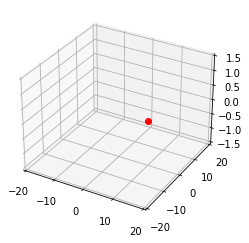

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe' 
# Replace '/path/to/ffmpeg' with the actual path to your FFmpeg executable.

# Parameters
sampling_frequency = 44100  # Hz
fps = 30  # Frames per second for display purposes
time_per_frame = 1 / fps  # Time per frame in seconds
time_per_sample = 1 / sampling_frequency  # Time per sample in seconds
samples_per_frame = int(time_per_frame / time_per_sample)  # Number of samples per frame

# Generate a set of 3D points
# Simulate a trajectory
t = np.linspace(0, 2 * np.pi, 44100)  # Time points for one second of data
#x = np.sin(t)
#y = np.cos(t)
#z = np.sin(2 * t)
#points = np.column_stack((x, y, z))  # Nx3 array of points

# Initialize the figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dot, = ax.plot([], [], [], 'o', color='red')  # The moving dot

# Set the limits of the axes
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-1.5, 1.5)

# Animation update function
def update(frame):
    # Calculate the range of points for the current frame
    start_idx = frame * samples_per_frame
    end_idx = start_idx + samples_per_frame
    if end_idx >= len(points):
        end_idx = len(points) - 1

    # Get the position of the dot for the current frame
    current_point = points[end_idx]
    print(current_point)

    # Update the position of the dot
    dot.set_data(current_point[0], current_point[1])
    dot.set_3d_properties(0)
    return dot,

sample_rate, data = wavfile.read("mid_tone.wav")
audio_data = np.array(data, dtype=np.float32)

# Create the animation
num_frames = len(data) // samples_per_frame
ani = FuncAnimation(fig, update, frames=num_frames, interval=1000 / fps, blit=True)
ani.save("dot_animation.mp4", writer="ffmpeg", fps=fps)
plt.show()



In [1]:
import subprocess

animation_file = "dot_animation.mp4"
audio_file = "mid_out.wav"
output_file = "audio_clip.mp4"

# FFmpeg command to merge video and audio
ffmpeg_command = [
    'ffmpeg',
    '-i', animation_file,  # Input video
    '-i', audio_file,      # Input audio
    '-c:v', 'copy',        # Copy video codec (no re-encoding)
    '-c:a', 'aac',         # Audio codec
    '-strict', 'experimental',
    '-shortest',           # Use the shortest duration between video and audio
    output_file
]

# Run FFmpeg command
try:
    subprocess.run(ffmpeg_command, check=True)
    print(f"Animation with audio saved as: {output_file}")
except subprocess.CalledProcessError as e:
    print("Error occurred while adding audio:", e)

Animation with audio saved as: audio_clip.mp4


In [19]:
from moviepy.editor import *

#audio_file = 'your_audio_file.mp3'  # Replace with your audio file
output_file = 'audio_video_out.mp4'

video_clip = VideoFileClip(animation_file)
audio_clip = AudioFileClip("mid_filtered_out.wav")

# Trim or loop audio to match video duration
audio_clip = audio_clip.set_duration(video_clip.duration)

new_audioclip = CompositeAudioClip([audio_clip])
video_clip.audio = new_audioclip
video_clip.write_videofile("final_out.mp4")

# Add the audio to the video
#final_clip = video_clip.set_audio(audio_clip)
#final_clip.write_videofile(output_file, codec='libx264', audio_codec='aac')

#print("Animation with audio saved as:", output_file)



Moviepy - Building video final_out.mp4.
MoviePy - Writing audio in final_outTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video final_out.mp4



Moviepy - Done !
Moviepy - video ready final_out.mp4


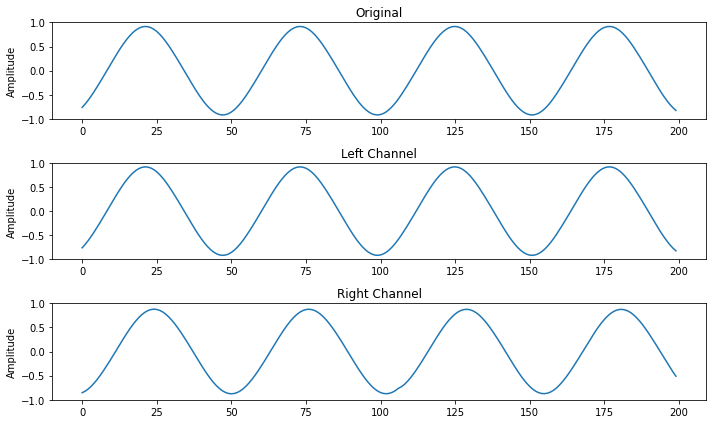

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Define sample rate and time duration
sample_rate = 44100
duration = 1  # seconds
num_samples = sample_rate * duration

# Create a time array for the x-axis
#time = np.linspace(0, duration, num_samples)

# Plot the audio data for 2 seconds
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(orig[2900:3100])
plt.title('Original')
plt.ylabel('Amplitude')
plt.ylim([-1,1])


plt.subplot(3, 1, 2)
plt.plot(left[2900:3100])
plt.title('Left Channel')
plt.ylabel('Amplitude')
plt.ylim([-1,1])


plt.subplot(3, 1, 3)
plt.plot(right[2900:3100])
plt.title('Right Channel')
plt.ylabel('Amplitude')
plt.ylim([-1,1])


plt.tight_layout()
plt.show()


In [18]:
spatialize_over_time("mid_tone.wav", "mid_filtered_out.wav", points)

whoopsy daisy


In [67]:
spatialize_over_time("mid_tone.wav", "in_front_mid_tone.wav", in_front_points)

whoopsy daisy


In [78]:
spatialize_over_time("mid_tone.wav", "mid_tone_left_channel_16.wav", left_points)

whoopsy daisy
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.

KeyboardInterrupt: 

In [38]:
spatialize_over_time("mid_tone.wav", "middle_right_channel.wav", right_middle_points)

NameError: name 'right_middle_points' is not defined

In [47]:
spatialize_over_time("mid_tone.wav", "mid_tone_right_channel_16.wav", right_points)

whoopsy daisy


In [44]:
left_r, orig_r, right_r = return_spatialized_channels("mid_tone.wav", "mid_tone_right_channel_16.wav", right_points)
print(left_r)

whoopsy daisy
0.0


TypeError: cannot unpack non-iterable NoneType object